In thsi notebook I train on the original (random play generated) data set but this optimizing winning not predciting the score 

In [20]:
#standard modukles
import numpy as np
import random as random
import time
import pandas as pd
#using simpleguitk for display, is not needed for computer game
#likely not needed un this notebook 
import simpleguitk as simplegui
#foor plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#for efficient saving and loading
import pickle
#skyjp game classes and functions
from skyjo_functions2 import *
#own functions for machine learning
from ml_functions2 import *
#for machine learning
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#time logging
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
#again tensorflow problem work before with conda install cudatoolkit, is not needed after each restart? 
#no is not enough still does not work  


import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix

Below I get the column names. 

In [4]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 
print(numeric.shape)
#selected rows array
sel1=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1[1]=1
#own card set
print(numeric[18:30,0])
sel1[18:30]=1
#other card set
print(numeric[30:42,0])
sel1[30:42]=1
#take open 
print(numeric[42])
sel1[42]=1
#discard
print(numeric[43])
sel1[43]=1
# discarded closed card
print(numeric[44])
sel1[44]=1
#id of selected player card
print(numeric[45])
sel1[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1[49]=1
print(numeric[50])
sel1[50]=1
print(sum(sel1))
print(numeric.shape)
# list of strings which will be pandas header
columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card')            
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print(len(columns))
#create copy which to be used fields  score not
sel2=np.copy(sel1)
sel2[48:51]=0
np.savetxt("xgb_model1_column2.txt",sel2)
print(sum(sel2))
print(sum(sel1))
print(sel2)
print(sel1)
print(columns[0:30])
print(columns[28])

(51, 30)
[20 20 20  7  9 20 20 20 20 20 20 20]
[ 1 20 20 20 20 20 20 20 20 20 20  4]
[1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1]
[0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0]
[30 -2 30 30 30 -1 30 30  5 30 11  7 30  0  4  0 30  9 30 30  9  9  9 30
 30 30 12  5 10 30]
[ 1  3  4  0  8  8  7  9  9  1  9  6  0  4 10  1  3 10  2  7  5  2 11  8
  7  9  7  6  6  6]
[20 20  9  1 20 20 20 20 20 20  2 20 20 20 20  5  7 20 20 20 20 20 20 -1
 -1  0 -1  7 20  5]
[166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61
 166  61 166  61 166  61 166  61 166  61 166  61]
[ 61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166
  61 166  61 166  61 166  61 166  61 166  61 166]
32.0
(51, 30)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'ot

In [5]:
#now withjthout taken card id for engering use 
sel1b=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1b[1]=1
#own card set
print(numeric[18:30,0])
sel1b[18:30]=1
#other card set
print(numeric[30:42,0])
sel1b[30:42]=1
#take open 
print(numeric[42])
sel1b[42]=1
#discard
print(numeric[43])
sel1b[43]=1
# discarded closed card
print(numeric[44])
sel1b[44]=1
#id of selected player card not anymore used 
#print(numeric[45])
#sel1b[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1b[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1b[49]=1
print(numeric[50])
sel1b[50]=1
print(sum(sel1b))
print(numeric.shape)
# list of strings which will be pandas header
columnsb=['open_pile_card']
for i in range(12):
    columnsb.append('own_cards_'+str(i))
for i in range(12):
    columnsb.append('other_player_cards_'+str(i))    
columnsb.append('action_take_open')
columnsb.append('action_discard')
columnsb.append('discard_value')
# not anymore used columnsb.append('id_player_card')
columnsb.append('numeric_player_card')            
columnsb.append('score_self')
columnsb.append('score_other')
columnsb.append('round')
print(columnsb)
print(len(columnsb))
#create copy which to be used fields  score not
sel2b=np.copy(sel1b)
sel2b[49:51]=0
np.savetxt("xgb_model2_column2.txt",sel2b)
print(sum(sel2b))
print(sum(sel1b))
print(sel2b)
print(sel1b)
print(columnsb[0:29])

[20 20 20  7  9 20 20 20 20 20 20 20]
[ 1 20 20 20 20 20 20 20 20 20 20  4]
[1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1]
[0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0]
[30 -2 30 30 30 -1 30 30  5 30 11  7 30  0  4  0 30  9 30 30  9  9  9 30
 30 30 12  5 10 30]
[20 20  9  1 20 20 20 20 20 20  2 20 20 20 20  5  7 20 20 20 20 20 20 -1
 -1  0 -1  7 20  5]
[166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61
 166  61 166  61 166  61 166  61 166  61 166  61]
[ 61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166  61 166
  61 166  61 166  61 166  61 166  61 166  61 166]
31.0
(51, 30)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_cards_5', 'other_pl

Thus in total it are 30 features and 1 target. The target is currently still in two different columns. 

One round is clearly not enough to train, not only because of the length of typically 32 data collections (turns), but also because the data is similar in the different turns. 
Thus, the data from many rounds needs to be collected. 


Below a check I check the function which collected many rounds.

Now I join the five difefernt data sets.

In [7]:
df1=pd.read_pickle('level_rand_v2_0_600000_0.pkl')
df2=pd.read_pickle('level_rand_v2_0_600000_1.pkl')
df3=pd.read_pickle('level_rand_v2_0_600000_2.pkl')
df4=pd.read_pickle('level_rand_v2_0_600000_3.pkl')
df5=pd.read_pickle('level_rand_v2_0_600000_4.pkl')
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)
#free space
df1=0
df2=0
df3=0
df4=0
df5=0

(600000, 33) (3000000, 33)


Now I add the summarizing columns. 

In [9]:
weight_vec=np.array([5/150,10/150,15/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150]) 
vals=np.array(range(-2,13))
print(vals)
av_value=np.dot(vals,weight_vec)
print(av_value)
df['own_n_closed']=df.loc[:,'own_cards_0':'own_cards_11'][df.loc[:,'own_cards_0':'own_cards_11']==20].count(axis=1)
#now n_open isstead because small n_vanished likely cases pron=blem in deep learning
df['own_n_open']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=30) & (df.loc[:,'own_cards_0':'own_cards_11']!=20)].count(axis=1)
df['own_max']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].max(axis=1)
df['own_sum']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].sum(axis=1)
df['other_player_n_closed']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][df.loc[:,'other_player_cards_0':'other_player_cards_11']==20].count(axis=1)
df['other_player_n_open']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].count(axis=1)
df['other_player_max']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].max(axis=1)
df['other_player_sum']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].sum(axis=1)
#replace placeholder with for closed with avg_value
df['value_player_card']=df['numeric_player_card']
df.value_player_card[df.numeric_player_card==20]=av_value
print(df.head())
print(df.columns)
#print(df.describe())
print(max(df.numeric_player_card),max(df.value_player_card))

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12]
5.066666666666666
   open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   round  own_n_closed  own_n_open  own_max  

In [ ]:
Now I am selecting then winning subset.


In [10]:
df_win=df[ (df.score_self<df.score_other)]
print(df_win.shape,df.shape)

(1496815, 42) (3000000, 42)


Now selecting the columns for training on take_open.

In [12]:
col_sel1=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','action_take_open']
col_sel2=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','discard_value','action_discard']
col_sel3=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','action_take_open','discard_value','value_player_card']
df_win_sel=df_win.loc[:,col_sel1]
print(df_win_sel.shape)

(1496815, 10)


Now I am splitting the data

In [18]:
feature_train,feature_test,target_train,target_test=split_test_valid(df_win_sel.iloc[:,0:9],df_win_sel.iloc[:,9],0.6)
print(feature_train.shape,feature_test.shape,target_test.shape,feature_train.head())

898089
(898089, 9) (598726, 9) (598726,)    open_pile_card  own_n_closed  own_n_open  own_sum  own_max  \
1               0             1          11     36.0     11.0   
4               4             2          10     28.0      9.0   
5               5             7           5     31.0     12.0   
7              12             3           9     42.0     12.0   
8               1             4           8     38.0      9.0   

   other_player_n_closed  other_player_n_open  other_player_sum  \
1                      4                    8              30.0   
4                      1                   11              63.0   
5                      7                    5              35.0   
7                      3                    9              59.0   
8                      7                    5              14.0   

   other_player_max  
1               9.0  
4              12.0  
5              11.0  
7              12.0  
8               8.0  


A first fit is done here. 

In [19]:
open1=XGBClassifier().fit(feature_train,target_train)
pred_te=open1.predict(feature_test)
pred_tr=open1.predict(feature_train)
conf_train = confusion_matrix(target_train, pred_tr)
conf_test = confusion_matrix(target_test, pred_te)
print(conf_train)
plt.figure(figsize = (6, 6));
sns.heatmap(conf_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("train")

[[264853 188164]
 [227352 217720]]


NameError: name 'sns' is not defined

<Figure size 600x600 with 0 Axes>

(<AxesSubplot:title={'center':'train'}>, Text(0.5, 1.0, 'train'))

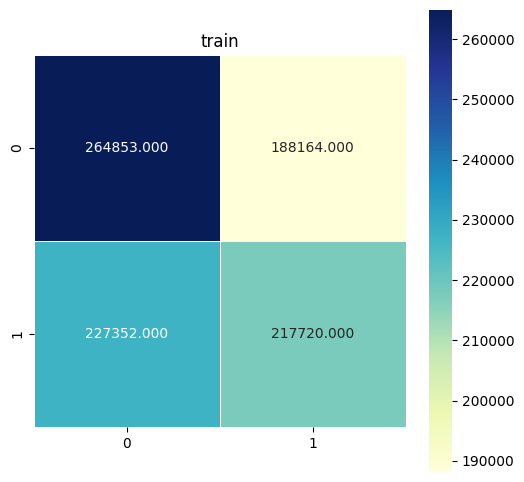

In [21]:

plt.figure(figsize = (6, 6));
sns.heatmap(conf_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("train")

Now I test the function and  get a first results. 

(<AxesSubplot:title={'center':'test'}>, Text(0.5, 1.0, 'test'))

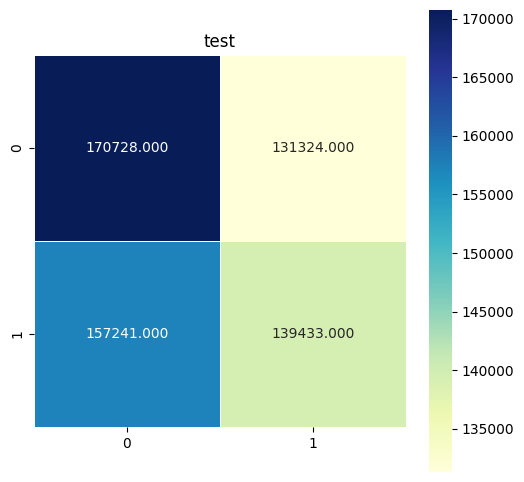

In [22]:

plt.figure(figsize = (6, 6));
sns.heatmap(conf_test, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("test")

Prediction is not good, likely a sign that it is not a good idea to train on winning for the original data set were there is a lot of randomness. 

In [24]:
for i in range(1,9):
    loop_reg(feature_train,target_train, feature_test,target_test,i,0.1,1.414,30,'take_open_random_xgb_depth'+str(i)+'.txt',False)

doing case 0
xgb took 7.9256 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 1
xgb took 7.5481 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 2
xgb took 7.2886 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 3
xgb took 7.3348 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 4
xgb took 7.3584 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 5
xgb took 7.3889 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 6
xgb took 7.049 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 7
xgb took 7.1155 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 8
xgb took 7.4921 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 9
xgb took 7.5057 seconds
percentage wrong test 48.06
percentage wrong train 47.97 
doing case 10
xgb took 7.6799 seconds
percentage wr

xgb took 10.4086 seconds
percentage wrong test 48.09
percentage wrong train 48.02 
doing case 27
xgb took 10.2513 seconds
percentage wrong test 48.09
percentage wrong train 48.03 
doing case 28
xgb took 10.1211 seconds
percentage wrong test 48.1
percentage wrong train 48.02 
doing case 29
xgb took 10.0244 seconds
percentage wrong test 48.13
percentage wrong train 48.02 
doing case 0
xgb took 27.5782 seconds
percentage wrong test 48.07
percentage wrong train 47.26 
doing case 1
xgb took 27.5415 seconds
percentage wrong test 48.05
percentage wrong train 47.29 
doing case 2
xgb took 27.3073 seconds
percentage wrong test 48.06
percentage wrong train 47.29 
doing case 3
xgb took 27.2318 seconds
percentage wrong test 48.03
percentage wrong train 47.28 
doing case 4
xgb took 27.227 seconds
percentage wrong test 48.05
percentage wrong train 47.24 
doing case 5
xgb took 27.2208 seconds
percentage wrong test 48.09
percentage wrong train 47.21 
doing case 6
xgb took 27.3426 seconds
percentage wro

percentage wrong test 47.99
percentage wrong train 47.66 
doing case 22
xgb took 22.215 seconds
percentage wrong test 47.99
percentage wrong train 47.75 
doing case 23
xgb took 22.5353 seconds
percentage wrong test 47.99
percentage wrong train 47.84 
doing case 24
xgb took 21.514 seconds
percentage wrong test 48.06
percentage wrong train 47.89 
doing case 25
xgb took 19.7814 seconds
percentage wrong test 48.06
percentage wrong train 47.95 
doing case 26
xgb took 18.2429 seconds
percentage wrong test 48.08
percentage wrong train 47.96 
doing case 27
xgb took 19.1746 seconds
percentage wrong test 48.1
percentage wrong train 47.97 
doing case 28
xgb took 18.6579 seconds
percentage wrong test 48.11
percentage wrong train 47.99 
doing case 29
xgb took 17.8326 seconds
percentage wrong test 48.12
percentage wrong train 48.0 
doing case 0
xgb took 66.7908 seconds
percentage wrong test 48.23
percentage wrong train 45.38 
doing case 1
xgb took 66.4174 seconds
percentage wrong test 48.31
percenta

In [28]:
tran1=np.loadtxt("take_open_random_xgb_depth1.txt")
tran2=np.loadtxt("take_open_random_xgb_depth2.txt")
tran3=np.loadtxt("take_open_random_xgb_depth3.txt")
tran4=np.loadtxt("take_open_random_xgb_depth4.txt")
tran5=np.loadtxt("take_open_random_xgb_depth5.txt")
tran6=np.loadtxt("take_open_random_xgb_depth6.txt")
tran7=np.loadtxt("take_open_random_xgb_depth7.txt")
tran8=np.loadtxt("take_open_random_xgb_depth8.txt")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran1[3]),4)} % of max-depth=1")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran2[3]),4)} % of max-depth=2")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran3[3]),4)} % of max-depth=3")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran4[3]),4)} % of max-depth=4")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran5[3]),4)} % of max-depth=5")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran6[3]),4)} % of max-depth=6")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran7[3]),4)} % of max-depth=7")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran8[3]),4)} % of max-depth=8")

minimum percent wrong of (prediction-test data) 48.0564 % of max-depth=1
minimum percent wrong of (prediction-test data) 48.0044 % of max-depth=2
minimum percent wrong of (prediction-test data) 47.9912 % of max-depth=3
minimum percent wrong of (prediction-test data) 47.9862 % of max-depth=4
minimum percent wrong of (prediction-test data) 47.978 % of max-depth=5
minimum percent wrong of (prediction-test data) 47.9857 % of max-depth=6
minimum percent wrong of (prediction-test data) 48.0033 % of max-depth=7
minimum percent wrong of (prediction-test data) 47.9657 % of max-depth=8


The regularization of the small % wrong is 204.12068079166409


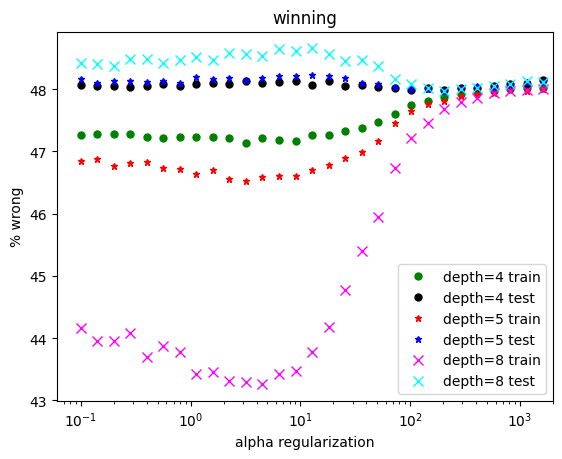

In [34]:
plt.plot(tran4[0,:],100*tran4[2,:],'o',ms=5,color='green',label='depth=4 train') 
plt.plot(tran4[0,:],100*tran4[3,:],'o',ms=5,color='black',label='depth=4 test') 
plt.plot(tran5[0,:],100*tran5[2,:],'*',ms=5,color='red',label='depth=5 train') 
plt.plot(tran5[0,:],100*tran5[3,:],'*',ms=5,color='blue',label='depth=5 test') 
plt.plot(tran8[0,:],100*tran8[2,:],'x',ms=7,color='magenta',label='depth=8 train') 
plt.plot(tran8[0,:],100*tran8[3,:],'x',ms=7,color='cyan',label='depth=8 test') 
plt.legend(loc="best")
plt.xscale('log')
plt.xlim(0,2000)
#plt.ylim(0,10)
plt.xlabel("alpha regularization")
plt.title("winning")
plt.ylabel("% wrong")
print(f"The regularization of the small % wrong is {tran8[0,np.argmin(tran8[3])]}") 

Has real minimum in test which has similar metric as train, but the improvement is small compared to flat, thus not clear whether it works. Also is slow, thus I will wait with the next part until later. 

In [ ]:

regxl29=XGBClassifier(max_depth=8,reg_alpha=204.12068079166409).fit(df_win_sel.iloc[:,0:9],df_win_sel.iloc[:,9])
#and save it
regxl29.save_model("xgb_model_open_ran1.json")



In [ ]:
regxl30=XGBClassifier()
regxl30.load_model("xgb_model1eb.json")
plt.plot(feature_train.columns,regxl30.feature_importances_,'o',ms=5,color='red',label='fitted on human win games') 
plt.plot(feature_train.columns,regxl29.feature_importances_,'o',ms=5,color='blue',label='fitted on random win games') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("take open True/False")
plt.xlabel("feature")
plt.ylabel("feature importance")